In [1]:
import pandas as pd
import seaborn as sns
import os
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.models as models
import torchaudio
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

os.chdir(r'C:\Users\777\Documents\dusha')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
pics = pd.read_csv('pics.csv')
pics

,dataset,pic_file_path,audio_path,emotion,speaker_emo
0,crowd,spectrogramsss\spec_00000d522439136554c888f4cf...,00000d522439136554c888f4cfd92131.wav,neutral,neutral
1,crowd,spectrogramsss\spec_000039c2bc753aa5a776621a47...,000039c2bc753aa5a776621a4707eb73.wav,neutral,neutral
2,crowd,spectrogramsss\spec_0002600403a116020fa591faf0...,0002600403a116020fa591faf05a31de.wav,positive,angry
3,crowd,spectrogramsss\spec_0002657bbce98b76b9832c8ad6...,0002657bbce98b76b9832c8ad6e4e6db.wav,neutral,neutral
4,crowd,spectrogramsss\spec_00028ec577ebf8a50bd617a9c0...,00028ec577ebf8a50bd617a9c0a5bc77.wav,positive,positive
...,...,...,...,...,...
158862,podcast,spectrograms\spec_fff71c6f1e2ee995b9a0972aeedd...,fff71c6f1e2ee995b9a0972aeedd2571.wav,neutral,NaN
158863,podcast,spectrograms\spec_fff9990e577d71d1d3caf09ca8c9...,fff9990e577d71d1d3caf09ca8c94770.wav,positive,NaN
158864,podcast,spectrograms\spec_fffac3a7ad57b97a89cca51792cd...,fffac3a7ad57b97a89cca51792cdfa95.wav,neutral,NaN
158865,podcast,spectrograms\spec_fffcfd5db45cd3db652651e53b5a...,fffcfd5db45cd3db652651e53b5afcd6.wav,neutral,NaN


In [3]:
dic = {'neutral':0, 'sad':1, 'positive':2, 'angry':3}
pics['emotion'] = pics['emotion'].map(dic)

In [4]:
pics

,dataset,pic_file_path,audio_path,emotion,speaker_emo
0,crowd,spectrogramsss\spec_00000d522439136554c888f4cf...,00000d522439136554c888f4cfd92131.wav,0,neutral
1,crowd,spectrogramsss\spec_000039c2bc753aa5a776621a47...,000039c2bc753aa5a776621a4707eb73.wav,0,neutral
2,crowd,spectrogramsss\spec_0002600403a116020fa591faf0...,0002600403a116020fa591faf05a31de.wav,2,angry
3,crowd,spectrogramsss\spec_0002657bbce98b76b9832c8ad6...,0002657bbce98b76b9832c8ad6e4e6db.wav,0,neutral
4,crowd,spectrogramsss\spec_00028ec577ebf8a50bd617a9c0...,00028ec577ebf8a50bd617a9c0a5bc77.wav,2,positive
...,...,...,...,...,...
158862,podcast,spectrograms\spec_fff71c6f1e2ee995b9a0972aeedd...,fff71c6f1e2ee995b9a0972aeedd2571.wav,0,NaN
158863,podcast,spectrograms\spec_fff9990e577d71d1d3caf09ca8c9...,fff9990e577d71d1d3caf09ca8c94770.wav,2,NaN
158864,podcast,spectrograms\spec_fffac3a7ad57b97a89cca51792cd...,fffac3a7ad57b97a89cca51792cdfa95.wav,0,NaN
158865,podcast,spectrograms\spec_fffcfd5db45cd3db652651e53b5a...,fffcfd5db45cd3db652651e53b5afcd6.wav,0,NaN


In [5]:
pics=pics.sample(65000)

In [6]:
print(pics.emotion.value_counts())

emotion
0    32611
1    12704
2    10379
3     9306
Name: count, dtype: int64


In [7]:
X = pics[pics.columns.drop(['dataset', 'audio_path', 'speaker_emo', 'emotion'])]
y = pd.DataFrame(pics[pics.columns[-2]])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=123)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of training examples: 46800


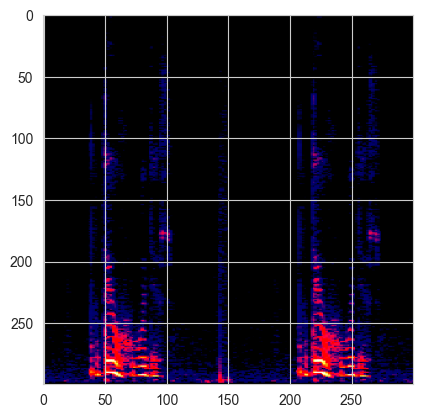

In [8]:
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import random
import matplotlib.pyplot as plt

# Создание CustomDataset
class ImageDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.images = X
        self.labels = y
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images.iloc[index, 0]  # Получаем путь к изображению по индексу
        image = np.array(Image.open(image_path))

        if self.transform:
            image = self.transform(image)

        label = self.labels.iloc[index, 0]  # Получаем метку класса по индексу

        return image, label

trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3, :, :]),  # Удаление альфа-канала
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #transforms.Lambda(lambda x: x.permute(1, 2, 0)),  # Перестановка размерностей
])


# Создание датасета с указанием пути к изображениям и меткам классов
dataset_train = ImageDataset(X_train, y_train, transform=trans)

# Получение длины датасета
dataset_length = len(X_train)
print('Number of training examples:', dataset_length)

# Генерация случайного индекса
random_index = 77

# Получение случайного элемента из датасета и его отображение
image, label = dataset_train[random_index]
plt.imshow(image.permute(1, 2, 0))
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of training examples: 18200


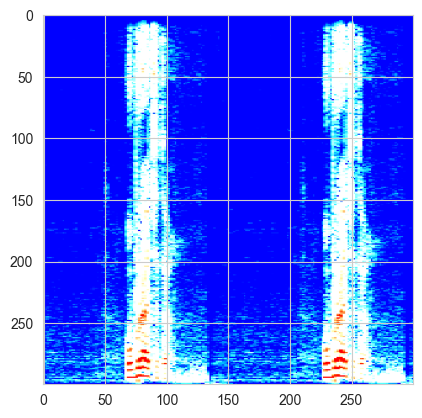

3


In [9]:
dataset_test = ImageDataset(X_test, y_test, transform=trans)

# Получение длины датасета
dataset_length = len(X_test)
print('Number of training examples:', dataset_length)

# Генерация случайного индекса
random_index = 55

# Получение случайного элемента из датасета и его отображение
image, label = dataset_test [random_index]
plt.imshow(image.permute(1, 2, 0))
plt.show()
print(label)

In [10]:

# Defining a custom data loader
dataloader_train = torch.utils.data.DataLoader(
    # Replace with the dataset object
    dataset=dataset_train,

    # Defining the batch size
    batch_size=128,

    # If true, shuffles the dataset at every epoch
    shuffle=True
)

# Get the length of the dataloader
# (Number of batches)
print('Number of batches:',len(dataloader_train))

Number of batches: 366


In [11]:
# Defining a custom data loader
dataloader_test = torch.utils.data.DataLoader(
    # Replace with the dataset object
    dataset=dataset_test,

    # Defining the batch size
    batch_size=128,

    # If true, shuffles the dataset at every epoch
    shuffle=True
)

# Get the length of the dataloader
# (Number of batches)
print('Number of batches:',len(dataloader_test))

Number of batches: 143


In [12]:
for data in dataloader_test:
    print(data)
    break

[tensor([[[[-1.1075, -1.1075, -1.1075,  ..., -1.0562, -1.0562, -0.2342],
          [-1.1075, -1.1075, -1.1075,  ..., -1.0733, -1.0733, -0.0116],
          [-1.1075, -1.1075, -1.1075,  ..., -1.1075, -1.1075, -0.3541],
          ...,
          [ 0.7933,  0.7933,  1.3242,  ...,  1.2728,  1.2728,  1.9064],
          [ 1.0844,  1.0844,  1.4954,  ...,  1.6495,  1.6495,  2.0263],
          [-0.1999, -0.1999, -0.4397,  ...,  0.2967,  0.2967,  1.7180]],

         [[-0.7052, -0.7052, -0.7052,  ..., -0.6176, -0.6176,  0.4853],
          [-0.7052, -0.7052, -0.7052,  ..., -0.6352, -0.6352,  0.7479],
          [-0.7052, -0.7052, -0.7052,  ..., -0.7052, -0.7052,  0.3452],
          ...,
          [ 1.4482,  1.4482,  1.7283,  ...,  1.7108,  1.7108,  1.6583],
          [ 1.6232,  1.6232,  1.7983,  ...,  1.8333,  1.8333,  1.4832],
          [ 0.5378,  0.5378,  0.2402,  ...,  1.0455,  1.0455,  1.7983]],

         [[ 1.5420,  1.5420,  1.5420,  ...,  1.6291,  1.6291,  2.4134],
          [ 1.5420,  1.5420, 

In [13]:
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.8),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.7),
            nn.Flatten(),
            nn.Linear(256 * 9 * 9, 1000),
            nn.LeakyReLU(),
            nn.Linear(1000, 4),
        )

    def forward(self, x):
        x = self.conv_stack(x)
        return x
model_cnn = CNN_model().to(device)

In [14]:
from torchsummary import summary
summary(model_cnn, (3,300,300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 300, 300]             896
         LeakyReLU-2         [-1, 32, 300, 300]               0
         MaxPool2d-3         [-1, 32, 150, 150]               0
            Conv2d-4         [-1, 32, 150, 150]           9,248
         LeakyReLU-5         [-1, 32, 150, 150]               0
            Conv2d-6         [-1, 64, 150, 150]          18,496
       BatchNorm2d-7         [-1, 64, 150, 150]             128
         LeakyReLU-8         [-1, 64, 150, 150]               0
            Conv2d-9         [-1, 64, 150, 150]          36,928
        LeakyReLU-10         [-1, 64, 150, 150]               0
          Dropout-11         [-1, 64, 150, 150]               0
           Conv2d-12        [-1, 128, 150, 150]          73,856
        LeakyReLU-13        [-1, 128, 150, 150]               0
        MaxPool2d-14          [-1, 128,

In [15]:
batch_size = 128
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
#model_cnn = CNN_model().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)


Using cuda device


In [16]:
from tqdm import tqdm
def accuracy(y_pred, y_acc):
    with torch.no_grad():
        return torch.sum(torch.max(torch.exp(y_pred), dim=1)[1] == y_acc).item() / len(y_acc)
def f1_f(y_pred, y_true):
    with torch.no_grad():
        y_pred = torch.max(torch.exp(y_pred), dim=1)[1].cpu().numpy()
        y_true = y_true.cpu().numpy()
        return f1_score(y_true, y_pred, average='weighted')

In [17]:
epochs = 9
trf1 = []
tsf1 =[]
tsa=[]
tra=[]
trls = []
tsls = []
cortrain = []
model = model_cnn
for e in range(1, epochs + 1):
    train_loss = 0
    train_acc = 0
    train_f1 = 0

    model_cnn.train()

    for imgs, labels in tqdm(dataloader_train, leave=True):
        pred = model(imgs.to(device))
        loss = loss_function(pred, labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy(pred, labels.to(device))
        train_f1 += f1_f(pred, labels)

    train_loss /= len(dataloader_train)
    train_acc /= len(dataloader_train)
    train_f1 /= len(dataloader_train)

    test_loss = 0
    test_acc = 0
    test_f1 = 0

    with torch.no_grad():
        model_cnn.eval()  # Переключаем модель в режим оценки

        for imgs, labels in tqdm(dataloader_test, leave=True):
            pred = model(imgs.to(device))
            loss = loss_function(pred, labels.to(device))

            test_loss += loss.item()
            test_acc += accuracy(pred, labels.to(device))
            test_f1 += f1_f(pred, labels)

    test_loss /= len(dataloader_test)
    test_acc /= len(dataloader_test)
    test_f1 /= len(dataloader_test)

    trf1.append(train_f1)
    tsf1.append(test_f1)
    tsa.append(test_acc)
    tra.append(train_acc)
    trls.append(train_loss)
    tsls.append(test_loss)

    print("Epoch {:4} | Train Loss {:.4f} | Train Acc {:.4f} | Train F1 {:.4f} | Test Loss {:.4f} | Test Acc {:.4f} | Test F1 {:.4f}".format(e, train_loss, train_acc, train_f1, test_loss, test_acc, test_f1))
    torch.save(model.state_dict(), f'cnn_spec_{e}.path')

100%|██████████| 143/143 [01:04<00:00,  2.21it/s]


Epoch    1 | Train Loss 1.2309 | Train Acc 0.5004 | Train F1 0.3373 | Test Loss 1.2080 | Test Acc 0.5051 | Test F1 0.3401


100%|██████████| 143/143 [00:48<00:00,  2.96it/s]


Epoch    2 | Train Loss 1.2001 | Train Acc 0.5031 | Train F1 0.3382 | Test Loss 1.1896 | Test Acc 0.5035 | Test F1 0.3389


100%|██████████| 143/143 [00:48<00:00,  2.95it/s]


Epoch    3 | Train Loss 1.1869 | Train Acc 0.5032 | Train F1 0.3381 | Test Loss 1.1706 | Test Acc 0.5047 | Test F1 0.3401


100%|██████████| 143/143 [00:48<00:00,  2.95it/s]


Epoch    4 | Train Loss 1.1764 | Train Acc 0.5029 | Train F1 0.3378 | Test Loss 1.1784 | Test Acc 0.5054 | Test F1 0.3407


100%|██████████| 143/143 [00:48<00:00,  2.95it/s]


Epoch    5 | Train Loss 1.1710 | Train Acc 0.5031 | Train F1 0.3380 | Test Loss 1.1601 | Test Acc 0.5042 | Test F1 0.3393


100%|██████████| 143/143 [00:48<00:00,  2.97it/s]


Epoch    6 | Train Loss 1.1702 | Train Acc 0.5027 | Train F1 0.3382 | Test Loss 1.1699 | Test Acc 0.5049 | Test F1 0.3398


100%|██████████| 143/143 [00:48<00:00,  2.95it/s]


Epoch    7 | Train Loss 1.1681 | Train Acc 0.5032 | Train F1 0.3381 | Test Loss 1.1683 | Test Acc 0.5056 | Test F1 0.3408


100%|██████████| 143/143 [00:48<00:00,  2.97it/s]


Epoch    8 | Train Loss 1.1679 | Train Acc 0.5031 | Train F1 0.3379 | Test Loss 1.1585 | Test Acc 0.5049 | Test F1 0.3398


100%|██████████| 143/143 [00:48<00:00,  2.95it/s]

Epoch    9 | Train Loss 1.2151 | Train Acc 0.5008 | Train F1 0.3400 | Test Loss 1.1959 | Test Acc 0.5056 | Test F1 0.3407


In [18]:
import torch
from sklearn.metrics import classification_report

# Получите предсказания модели на тестовом наборе данных
predictions = []
true_labels = []

model.eval()  # Переведем модель в режим оценки
with torch.no_grad():
    for imgs, labels in dataloader_test:
        preds = model(imgs.to(device))
        _, predicted = torch.max(preds, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Оцените производительность модели с помощью classification_report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67      9194
           1       0.00      0.00      0.00      3603
           2       0.00      0.00      0.00      2851
           3       0.00      0.00      0.00      2552

    accuracy                           0.51     18200
   macro avg       0.13      0.25      0.17     18200
weighted avg       0.26      0.51      0.34     18200



C:\Users\777\Documents\dusha\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\777\Documents\dusha\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\777\Documents\dusha\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


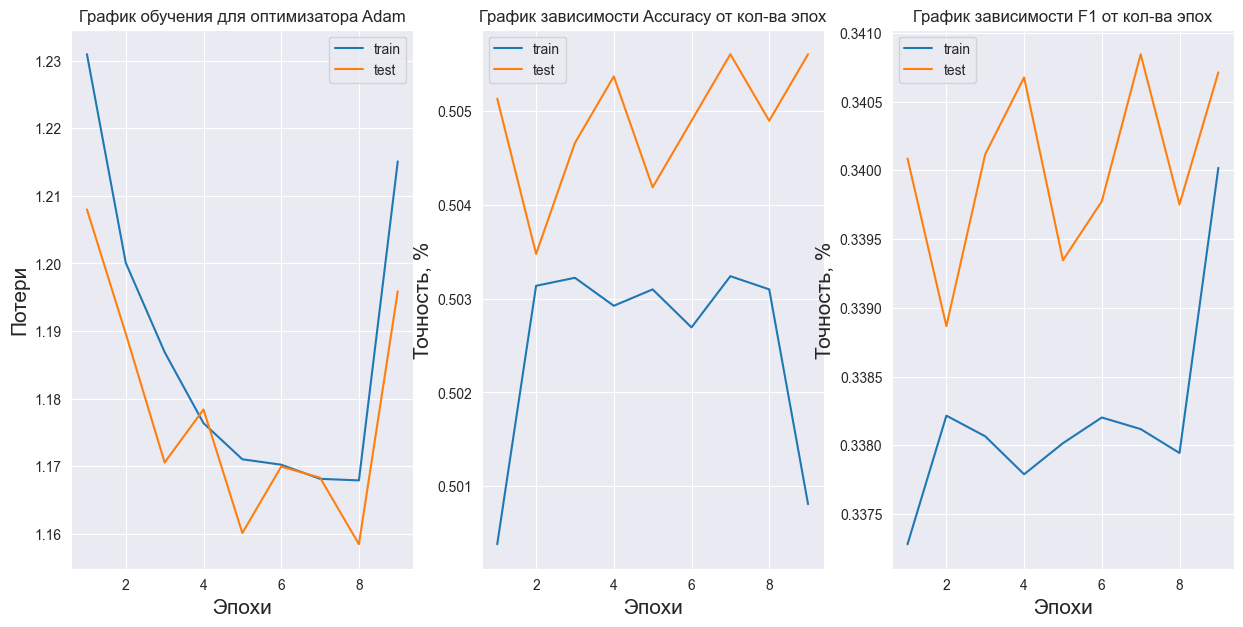

In [19]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
plt.plot(range(1, e + 1), trls, label="train")
plt.plot(range(1, e + 1), tsls, label="test")
plt.xlabel("Эпохи", fontsize=15)
plt.ylabel("Потери", fontsize=15)
plt.title("График обучения для оптимизатора Adam")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(range(1, e + 1), tra, label="train")
plt.plot(range(1, e + 1), tsa, label="test")
plt.xlabel("Эпохи", fontsize=15)
plt.ylabel("Точность, %", fontsize=15)
plt.legend()
plt.title("График зависимости Accuracy от кол-ва эпох")
plt.subplot(1, 3, 3)
plt.plot(range(1, e + 1), trf1, label="train")
plt.plot(range(1, e + 1), tsf1, label="test")
plt.xlabel("Эпохи", fontsize=15)
plt.ylabel("Точность, %", fontsize=15)
plt.legend()
plt.title("График зависимости F1 от кол-ва эпох")
plt.grid
plt.show()

In [13]:
torch.cuda.empty_cache()

### ничего хорошего не получилось

{'neutral':0, 'sad':1, 'positive':2, 'angry':3}

In [10]:
class CustomAudioDS(Dataset):

    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate, num_samples, device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        dataset = self._get_audio_sample_dataset(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self.transformation(signal)
        return signal, label, dataset

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_of_signal = signal.shape[1]
        if length_of_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_of_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate).to(device)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim= True)
        return signal

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[index, 1])
        return path

    def _get_audio_sample_label(self, index):
        return int(self.annotations.iloc[index, 3])

    def _get_audio_sample_dataset(self, index):
         return self.annotations.iloc[index, -1]



def accuracy(y_pred, y_acc):
    with torch.no_grad():
        return torch.sum(torch.max(torch.exp(y_pred), dim=1)[1] == y_acc).item() / len(y_acc)


def f1_f(y_pred, y_true):
    with torch.no_grad():
        y_pred = torch.max(torch.exp(y_pred), dim=1)[1].cpu().numpy()
        y_true = y_true.cpu().numpy()
        return f1_score(y_true, y_pred, average='weighted')




In [11]:
annotations_file_train = 'major_train_balanced_small.csv'
audio_dir_train = 'DATASET_PATH/wavs_train'
sample_rate = 22050
NUM_SAMPLES = 131072
annotations_file_test = 'major_test_dataset.csv'
audio_dir_test = 'DATASET_PATH/wavs_test'


mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=1024, hop_length=256, n_mels=128)

In [12]:
pic_ds_train= CustomAudioDS(annotations_file_train, audio_dir_train, mel_spectrogram, sample_rate, NUM_SAMPLES, device)
pic_ds_test = CustomAudioDS(annotations_file_test, audio_dir_test, mel_spectrogram, sample_rate, NUM_SAMPLES, device)


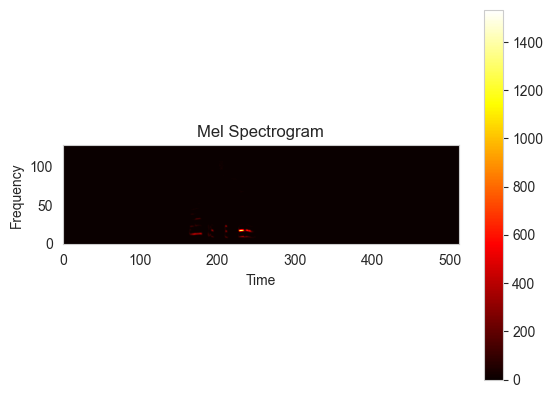

In [13]:
mel = pic_ds_train[654][0][0].to('cpu')
mel_spec_np = mel.detach().numpy()

# Отображение мелспектрограммы

plt.imshow(mel_spec_np, cmap='hot', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Mel Spectrogram')
plt.colorbar()
plt.grid(False)
plt.show()

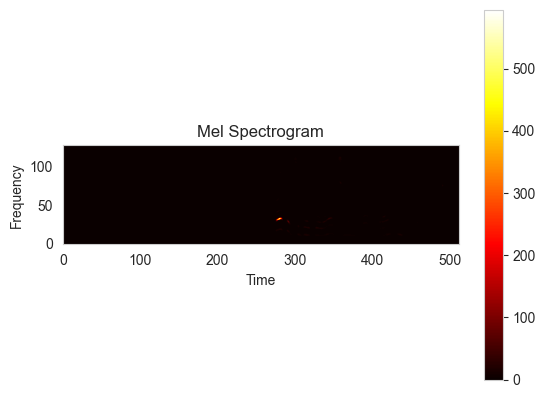

In [14]:
mel = pic_ds_test[1223][0][0].to('cpu')
mel_spec_np = mel.detach().numpy()

# Отображение мелспектрограммы

plt.imshow(mel_spec_np, cmap='hot', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Mel Spectrogram')
plt.colorbar()
plt.grid(False)
plt.show()

In [15]:
def create_loader(data, batch_size):
    dataloader = DataLoader(data, batch_size=batch_size)
    return dataloader

In [16]:
batch_size = 128
dataloader_train = create_loader(pic_ds_train, batch_size)
dataloader_test = create_loader(pic_ds_test, batch_size)

In [17]:
for x,y,z in dataloader_train:
    print(y)
    break


tensor([1, 0, 2, 3, 2, 0, 0, 2, 0, 2, 0, 0, 1, 0, 1, 0, 1, 1, 2, 0, 1, 3, 0, 2,
        1, 3, 2, 0, 0, 2, 0, 3, 2, 3, 0, 3, 2, 3, 1, 1, 0, 1, 2, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 3, 1, 0, 2, 2, 3, 1, 1, 0, 0, 2, 1, 0, 2, 2, 3, 2, 0, 0, 0,
        0, 2, 2, 2, 1, 0, 3, 1, 2, 0, 1, 3, 1, 1, 2, 1, 3, 0, 1, 1, 1, 2, 0, 2,
        0, 2, 1, 0, 0, 2, 3, 0, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 3, 3, 1, 0, 3, 0,
        0, 1, 1, 0, 1, 3, 1, 0])


In [22]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.LeakyReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()

        )


        self.conv6 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128*16*64, 4)

    def forward(self, input):
        x= self.conv1(input)
        x= self.conv2(x)
        x= self.conv4(x)
        x= self.conv5(x)
        x= self.conv6(x)
        x = self.flatten(x)
        logits = self.linear(x)


        return logits

In [18]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.8),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.7),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(256 * 4 * 16, 1000),
            nn.LeakyReLU(),
            nn.Linear(1000, 4),
        )

    def forward(self, x):
        x = self.conv_stack(x)
        return x

In [24]:
# старая модель есть сохры

class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            #nn.Conv2d(64, 64, 3, padding=1),
            #nn.BatchNorm2d(64),
            #nn.LeakyReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.7),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(256 * 16 * 64, 1000),
            nn.LeakyReLU(),
            nn.Linear(1000, 4),
        )

    def forward(self, x):
        x = self.conv_stack(x)
        return x

In [19]:
from torchsummary import summary
model_cnn = CNNNetwork()
model_cnn = model_cnn.to(device)
summary(model_cnn, (1, 128, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 512]             320
       BatchNorm2d-2         [-1, 32, 128, 512]              64
         LeakyReLU-3         [-1, 32, 128, 512]               0
            Conv2d-4         [-1, 32, 128, 512]           9,248
         LeakyReLU-5         [-1, 32, 128, 512]               0
         MaxPool2d-6          [-1, 32, 64, 256]               0
            Conv2d-7          [-1, 64, 64, 256]          18,496
         LeakyReLU-8          [-1, 64, 64, 256]               0
         MaxPool2d-9          [-1, 64, 32, 128]               0
           Conv2d-10          [-1, 64, 32, 128]          36,928
      BatchNorm2d-11          [-1, 64, 32, 128]             128
        LeakyReLU-12          [-1, 64, 32, 128]               0
          Dropout-13          [-1, 64, 32, 128]               0
           Conv2d-14         [-1, 128, 

In [41]:
model = CNNNetwork()
epochs = 4
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

In [37]:
epochs = 8
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

In [27]:
from tqdm import tqdm
def accuracy(y_pred, y_acc):
    with torch.no_grad():
        return torch.sum(torch.max(torch.exp(y_pred), dim=1)[1] == y_acc).item() / len(y_acc)
def f1_f(y_pred, y_true):
    with torch.no_grad():
        y_pred = torch.max(torch.exp(y_pred), dim=1)[1].cpu().numpy()
        y_true = y_true.cpu().numpy()
        return f1_score(y_true, y_pred, average='weighted')

In [39]:
trf1 = []
tsf1 = []
tsa = []
tra = []
trls = []
tsls = []
model = model_cnn

In [42]:
epochs = 12
for e in range(1, epochs + 1):
    train_loss = 0
    train_acc = 0
    train_f1 = 0
    model.train()
    for batch in tqdm(dataloader_train, leave=True):
        x, y, dataset = batch
        x, y = x.cuda(), y.cuda()
        # Forward pass and backprop
        out= model_cnn(x)
        loss = loss_function(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy(out, y)
        train_f1 += f1_f(out, y)

    print(loss.item(), 'train loss item')
    # Scale accuracy and losses
    train_loss /= len(dataloader_train)
    train_acc /= len(dataloader_train)
    train_f1 /= len(dataloader_train)

    test_loss = 0
    test_acc = 0
    test_f1 = 0

    with torch.no_grad():
        for batch in tqdm(dataloader_test, leave=True):
            x, y, dataset = batch
            x, y = x.cuda(), y.cuda()
            out = model_cnn(x)
            loss = loss_function(out, y)
            test_loss += loss.item()
            test_acc += accuracy(out, y)
            test_f1 += f1_f(out, y)

        print(loss.item(), 'test loss item')

    test_loss /= len(dataloader_test)
    test_acc /= len(dataloader_test)
    test_f1 /= len(dataloader_test)
    trf1.append(train_f1)
    tsf1.append(test_f1)
    tsa.append(test_acc)
    tra.append(train_acc)
    trls.append(train_loss)
    tsls.append(test_loss)

    print(
        "Epoch {:4} | Train Loss {:.4f} | Train Acc {:.4f} | Train F1 {:.4f} | Test Loss {:.4f} | Test Acc {:.4f} | Test F1 {:.4f}".format(
            e+12, train_loss, train_acc, train_f1, test_loss, test_acc, test_f1))

    torch.save(model.state_dict(), f'Deeper_CNNMels_deep_balanced_epoch_{e+12}.pth')

100%|██████████| 508/508 [13:00<00:00,  1.54s/it]


0.9293648600578308 train loss item


100%|██████████| 227/227 [02:31<00:00,  1.50it/s]


0.653390109539032 test loss item
Epoch   13 | Train Loss 0.8786 | Train Acc 0.6391 | Train F1 0.6360 | Test Loss 0.9384 | Test Acc 0.6063 | Test F1 0.6395


100%|██████████| 508/508 [12:30<00:00,  1.48s/it]


0.9245760440826416 train loss item


100%|██████████| 227/227 [02:24<00:00,  1.57it/s]

0.6103312373161316 test loss item
Epoch   14 | Train Loss 0.8700 | Train Acc 0.6428 | Train F1 0.6397 | Test Loss 0.9371 | Test Acc 0.6064 | Test F1 0.6419


In [42]:
torch.cuda.empty_cache()

In [17]:
cnn = CNNNetwork()
cnn.to(device)
state_dict = torch.load('CNNMels_deep_balanced_epoch_7.pth')
cnn.load_state_dict(state_dict)
model = cnn


In [18]:
predictions = []
true_labels = []
model.eval()
with torch.no_grad():
    for batch in tqdm(dataloader_test, leave=True):
        x, y, dataset = batch
        x, y = x.cuda(), y.cuda()
        out = model(x)
        loss = loss_function(out, y)
        _, predicted = torch.max(out, 1)

        predictions.extend(predicted.cpu().tolist())
        true_labels.extend(y.cpu().tolist())



100%|██████████| 227/227 [02:35<00:00,  1.46it/s]


In [74]:


conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

print(f'Accuracy: {round(accuracy_score(true_labels, predictions) * 100, 2)}%')
print(f'Precision score: {round(precision_score(true_labels, predictions, average="macro") * 100, 2)}%')
print(f'Recall score: {round(recall_score(true_labels, predictions, average="macro") * 100, 2)}%')
print(f'f1 score: {round(f1_score(true_labels, predictions, average="weighted") * 100, 2)}%')

class_names = ['neutral', 'angry', 'positive', 'sad']  # Замените классы на реальные
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


Confusion Matrix:
[[13004  5988   927  1124]
 [  433  2694    81    89]
 [  947   356   973   227]
 [  476   249   251  1215]]
Accuracy: 61.6%
Precision score: 51.47%
Recall score: 59.46%
f1 score: 64.69%
Classification Report:
              precision    recall  f1-score   support

     neutral       0.88      0.62      0.72     21043
       angry       0.29      0.82      0.43      3297
    positive       0.44      0.39      0.41      2503
         sad       0.46      0.55      0.50      2191

    accuracy                           0.62     29034
   macro avg       0.51      0.59      0.52     29034
weighted avg       0.74      0.62      0.65     29034



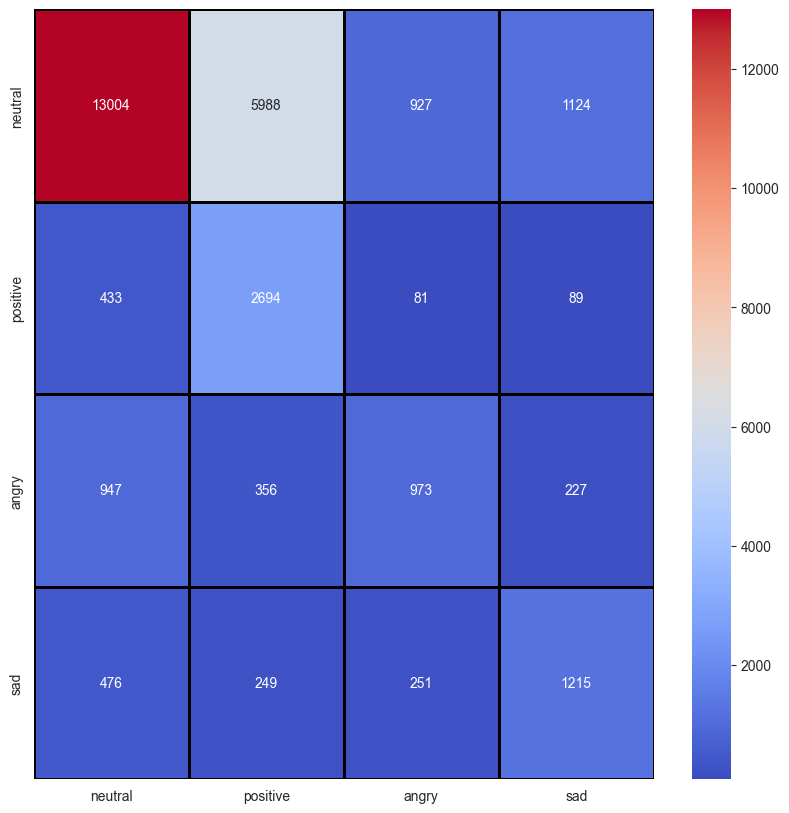

In [75]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(true_labels, predictions), annot=True, cmap='coolwarm', linewidths=2, linecolor='black',
            fmt=str(), xticklabels=pics.emotion.unique(), yticklabels=pics.emotion.unique())
plt.show()


In [38]:
cnn = CNNNetwork()
cnn.to(device)
state_dict = torch.load('CNNMels_deep_balanced_epoch_8.pth')
cnn.load_state_dict(state_dict)
model = cnn
loss_function = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)
predictions = []
true_labels = []
model.eval()
with torch.no_grad():
    for batch in tqdm(dataloader_test, leave=True):
        x, y, dataset = batch
        x, y = x.cuda(), y.cuda()
        out = model(x)
        loss = loss_function(out, y)
        _, predicted = torch.max(out, 1)

        predictions.extend(predicted.cpu().tolist())
        true_labels.extend(y.cpu().tolist())

100%|██████████| 227/227 [00:55<00:00,  4.06it/s]


In [39]:
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

print(f'Accuracy: {round(accuracy_score(true_labels, predictions) * 100, 2)}%')
print(f'Precision score: {round(precision_score(true_labels, predictions, average="macro") * 100, 2)}%')
print(f'Recall score: {round(recall_score(true_labels, predictions, average="macro") * 100, 2)}%')
print(f'f1 score: {round(f1_score(true_labels, predictions, average="weighted") * 100, 2)}%')

class_names = ['neutral', 'angry', 'positive', 'sad']  # Замените классы на реальные
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))

Confusion Matrix:
[[11532  6019   857  2635]
 [  322  2525    78   372]
 [  915   445   792   351]
 [  418   283   213  1277]]
Accuracy: 55.54%
Precision score: 45.76%
Recall score: 55.33%
f1 score: 59.29%
Classification Report:
              precision    recall  f1-score   support

     neutral       0.87      0.55      0.67     21043
       angry       0.27      0.77      0.40      3297
    positive       0.41      0.32      0.36      2503
         sad       0.28      0.58      0.37      2191

    accuracy                           0.56     29034
   macro avg       0.46      0.55      0.45     29034
weighted avg       0.72      0.56      0.59     29034



In [49]:
cnn = CNNNetwork()
cnn.to(device)
state_dict = torch.load('Deeper_CNNMels_deep_balanced_epoch_13.pth')
cnn.load_state_dict(state_dict)
model = cnn
loss_function = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)
predictions = []
true_labels = []
model.eval()
with torch.no_grad():
    for batch in tqdm(dataloader_test, leave=True):
        x, y, dataset = batch
        x, y = x.cuda(), y.cuda()
        out = model(x)
        loss = loss_function(out, y)
        _, predicted = torch.max(out, 1)

        predictions.extend(predicted.cpu().tolist())
        true_labels.extend(y.cpu().tolist())

100%|██████████| 227/227 [00:52<00:00,  4.30it/s]


In [50]:
# best model 'Deeper_CNNMels_deep_balanced_epoch_13.pth'
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

print(f'Accuracy: {round(accuracy_score(true_labels, predictions) * 100, 2)}%')
print(f'Precision score: {round(precision_score(true_labels, predictions, average="macro") * 100, 2)}%')
print(f'Recall score: {round(recall_score(true_labels, predictions, average="macro") * 100, 2)}%')
print(f'f1 score: {round(f1_score(true_labels, predictions, average="weighted") * 100, 2)}%')

class_names = ['neutral', 'angry', 'positive', 'sad']  # Замените классы на реальные
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))

Confusion Matrix:
[[13365  5130  1065  1483]
 [  483  2543   122   149]
 [  999   249   984   271]
 [  499   161   240  1291]]
Accuracy: 62.63%
Precision score: 49.95%
Recall score: 59.72%
f1 score: 65.38%
Classification Report:
              precision    recall  f1-score   support

     neutral       0.87      0.64      0.73     21043
       angry       0.31      0.77      0.45      3297
    positive       0.41      0.39      0.40      2503
         sad       0.40      0.59      0.48      2191

    accuracy                           0.63     29034
   macro avg       0.50      0.60      0.52     29034
weighted avg       0.73      0.63      0.65     29034



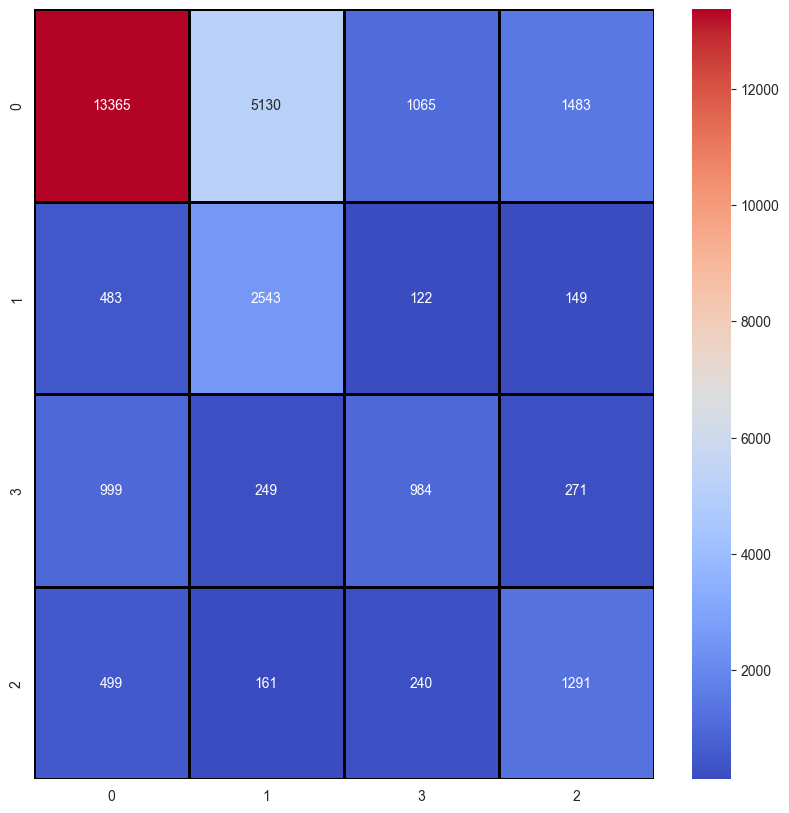

In [51]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(true_labels, predictions), annot=True, cmap='coolwarm', linewidths=2, linecolor='black',
            fmt=str(), xticklabels=pics.emotion.unique(), yticklabels=pics.emotion.unique())
plt.show()

## resnet


In [52]:
class myresn(nn.Module):
    def __init__(self):
        super(myresn, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2))

        self.resblock1 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.8)),
            nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.8)))

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2))


        self.resblock2 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.7)),
            nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.7)))

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2))

        self.resblock3 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.7)),
            nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.7)))

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2))

        self.resblock4 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.6)),
            nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.6)))


        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.6),
            nn.MaxPool2d(2))

        self.classifier = nn.Sequential(

            nn.Flatten(),
            nn.Linear(512 * 2 * 8, 1000),
            nn.LeakyReLU(),
            nn.Linear(1000, 4),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.resblock1(x) + x
        x = self.conv3(x)
        x = self.resblock2(x) + x
        x = self.conv4(x)
        x = self.resblock3(x) + x
        x = self.conv5(x)
        x = self.resblock4(x) + x
        x = self.conv6(x)
        x = self.classifier(x)

        return x

In [53]:
myres_model = myresn().to(device)
summary(myres_model, (1, 128, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 512]             320
       BatchNorm2d-2         [-1, 32, 128, 512]              64
         LeakyReLU-3         [-1, 32, 128, 512]               0
         MaxPool2d-4          [-1, 32, 64, 256]               0
            Conv2d-5          [-1, 64, 64, 256]          18,496
       BatchNorm2d-6          [-1, 64, 64, 256]             128
         LeakyReLU-7          [-1, 64, 64, 256]               0
         MaxPool2d-8          [-1, 64, 32, 128]               0
            Conv2d-9          [-1, 64, 32, 128]          36,928
        LeakyReLU-10          [-1, 64, 32, 128]               0
          Dropout-11          [-1, 64, 32, 128]               0
           Conv2d-12          [-1, 64, 32, 128]          36,928
        LeakyReLU-13          [-1, 64, 32, 128]               0
          Dropout-14          [-1, 64, 

In [54]:
num_epochs = 11
batch_size = 128
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
myres_model = myresn().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(myres_model.parameters(), lr=learning_rate, weight_decay=1e-3, amsgrad=True)

In [55]:
from tqdm import tqdm


def accuracy(y_pred, y_acc):
    with torch.no_grad():
        return torch.sum(torch.max(torch.exp(y_pred), dim=1)[1] == y_acc).item() / len(y_acc)


def f1_f(y_pred, y_true):
    with torch.no_grad():
        y_pred = torch.max(torch.exp(y_pred), dim=1)[1].cpu().numpy()
        y_true = y_true.cpu().numpy()
        return f1_score(y_true, y_pred, average='weighted')



In [56]:

trf1 = []
tsf1 = []
tsa = []
tra = []
trls = []
tsls = []
model = myres_model
epochs = 11
for e in range(1, epochs + 1):
    train_loss = 0
    train_acc = 0
    train_f1 = 0
    model.train()
    for batch in tqdm(dataloader_train, leave=True):
        x, y, dataset = batch
        x, y = x.cuda(), y.cuda()
        # Forward pass and backprop
        out = model(x)
        loss = loss_function(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy(out, y)
        train_f1 += f1_f(out, y)

    print(loss.item(), 'train loss item')
    # Scale accuracy and losses
    train_loss /= len(dataloader_train)
    train_acc /= len(dataloader_train)
    train_f1 /= len(dataloader_train)

    test_loss = 0
    test_acc = 0
    test_f1 = 0

    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader_test, leave=True):
            x, y, dataset = batch
            x, y = x.cuda(), y.cuda()
            out = model(x)
            loss = loss_function(out, y)
            test_loss += loss.item()
            test_acc += accuracy(out, y)
            test_f1 += f1_f(out, y)

        print(loss.item(), 'test loss item')

    test_loss /= len(dataloader_test)
    test_acc /= len(dataloader_test)
    test_f1 /= len(dataloader_test)
    trf1.append(train_f1)
    tsf1.append(test_f1)
    tsa.append(test_acc)
    tra.append(train_acc)
    trls.append(train_loss)
    tsls.append(test_loss)

    print(
        "Epoch {:4} | Train Loss {:.4f} | Train Acc {:.4f} | Train F1 {:.4f} | Test Loss {:.4f} | Test Acc {:.4f} | Test F1 {:.4f}".format(
            e + 12, train_loss, train_acc, train_f1, test_loss, test_acc, test_f1))

    torch.save(model.state_dict(), f'resnet_{e }.pth')

100%|██████████| 508/508 [05:43<00:00,  1.48it/s]


1.1947497129440308 train loss item


100%|██████████| 227/227 [01:08<00:00,  3.30it/s]


1.0177825689315796 test loss item
Epoch   13 | Train Loss 1.3010 | Train Acc 0.4394 | Train F1 0.4060 | Test Loss 1.1793 | Test Acc 0.4441 | Test F1 0.4417


100%|██████████| 508/508 [02:57<00:00,  2.86it/s]


1.1248650550842285 train loss item


100%|██████████| 227/227 [00:57<00:00,  3.97it/s]


1.0127965211868286 test loss item
Epoch   14 | Train Loss 1.1751 | Train Acc 0.4679 | Train F1 0.4385 | Test Loss 1.1971 | Test Acc 0.3529 | Test F1 0.3473


100%|██████████| 508/508 [02:29<00:00,  3.40it/s]


1.130271077156067 train loss item


100%|██████████| 227/227 [00:55<00:00,  4.11it/s]


0.9038213491439819 test loss item
Epoch   15 | Train Loss 1.1397 | Train Acc 0.4896 | Train F1 0.4634 | Test Loss 1.1018 | Test Acc 0.5377 | Test F1 0.5393


100%|██████████| 508/508 [02:27<00:00,  3.44it/s]


1.1450469493865967 train loss item


100%|██████████| 227/227 [00:54<00:00,  4.15it/s]


0.9085745811462402 test loss item
Epoch   16 | Train Loss 1.1181 | Train Acc 0.5045 | Train F1 0.4833 | Test Loss 1.1578 | Test Acc 0.4353 | Test F1 0.4117


100%|██████████| 508/508 [02:26<00:00,  3.47it/s]


1.1060580015182495 train loss item


100%|██████████| 227/227 [00:54<00:00,  4.18it/s]


1.1023266315460205 test loss item
Epoch   17 | Train Loss 1.1036 | Train Acc 0.5131 | Train F1 0.4943 | Test Loss 1.3228 | Test Acc 0.2893 | Test F1 0.2836


100%|██████████| 508/508 [02:26<00:00,  3.46it/s]


1.0644999742507935 train loss item


100%|██████████| 227/227 [00:54<00:00,  4.16it/s]


0.9778203964233398 test loss item
Epoch   18 | Train Loss 1.0906 | Train Acc 0.5226 | Train F1 0.5067 | Test Loss 1.2660 | Test Acc 0.3913 | Test F1 0.3692


100%|██████████| 508/508 [02:26<00:00,  3.47it/s]


1.0633409023284912 train loss item


100%|██████████| 227/227 [00:54<00:00,  4.16it/s]


0.9509627819061279 test loss item
Epoch   19 | Train Loss 1.0736 | Train Acc 0.5322 | Train F1 0.5184 | Test Loss 1.2172 | Test Acc 0.3961 | Test F1 0.3743


 80%|███████▉  | 404/508 [01:59<00:30,  3.38it/s]


KeyboardInterrupt: 

In [57]:
myres_model = myresn().to(device)
myres_model.to(device)
state_dict = torch.load('resnet_3.pth')
myres_model.load_state_dict(state_dict)
model = myres_model
loss_function = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)
predictions = []
true_labels = []
model.eval()
with torch.no_grad():
    for batch in tqdm(dataloader_test, leave=True):
        x, y, dataset = batch
        x, y = x.cuda(), y.cuda()
        out = model(x)
        loss = loss_function(out, y)
        _, predicted = torch.max(out, 1)

        predictions.extend(predicted.cpu().tolist())
        true_labels.extend(y.cpu().tolist())
# best model 'Deeper_CNNMels_deep_balanced_epoch_13.pth'
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

print(f'Accuracy: {round(accuracy_score(true_labels, predictions) * 100, 2)}%')
print(f'Precision score: {round(precision_score(true_labels, predictions, average="macro") * 100, 2)}%')
print(f'Recall score: {round(recall_score(true_labels, predictions, average="macro") * 100, 2)}%')
print(f'f1 score: {round(f1_score(true_labels, predictions, average="weighted") * 100, 2)}%')

class_names = ['neutral', 'angry', 'positive', 'sad']  # Замените классы на реальные
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))

100%|██████████| 227/227 [00:54<00:00,  4.20it/s]

Confusion Matrix:
[[11920  7636   547   940]
 [  450  2717    41    89]
 [ 1247   504   371   381]
 [  875   433   287   596]]
Accuracy: 53.74%
Precision score: 41.45%
Recall score: 45.27%
f1 score: 56.7%
Classification Report:
              precision    recall  f1-score   support

     neutral       0.82      0.57      0.67     21043
       angry       0.24      0.82      0.37      3297
    positive       0.30      0.15      0.20      2503
         sad       0.30      0.27      0.28      2191

    accuracy                           0.54     29034
   macro avg       0.41      0.45      0.38     29034
weighted avg       0.67      0.54      0.57     29034



## Tensorflow 1D

In [7]:
import librosa
import numpy as np
sample_rate = 16000

def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    return result

In [8]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    return result


In [9]:
pics

,dataset,pic_file_path,audio_path,emotion,speaker_emo
88137,crowd,spectrogramsss\spec_c079146806f9fe42f7aaa38b66...,c079146806f9fe42f7aaa38b668fbefa.wav,0,sad
18503,crowd,spectrogramsss\spec_287edba6c2a56933dadccb8834...,287edba6c2a56933dadccb8834f072a5.wav,0,NaN
76563,crowd,spectrogramsss\spec_a79311f87d90c376b242ba9930...,a79311f87d90c376b242ba993034fae5.wav,3,angry
69191,crowd,spectrogramsss\spec_974ec597fbd273a5ccb53b39f1...,974ec597fbd273a5ccb53b39f173f84f.wav,0,NaN
116224,crowd,spectrogramsss\spec_fe7e910b9dbe197dfa812d51f7...,fe7e910b9dbe197dfa812d51f7fce212.wav,3,NaN
...,...,...,...,...,...
65067,crowd,spectrogramsss\spec_8de685c823ca4b72ebfb0552f1...,8de685c823ca4b72ebfb0552f10ea35e.wav,0,NaN
128338,podcast,spectrograms\spec_452b28d24aa98e5ec6163793981c...,452b28d24aa98e5ec6163793981c3356.wav,0,NaN
151034,podcast,spectrograms\spec_cf832fb001848d5de2d81ce9d001...,cf832fb001848d5de2d81ce9d00181c2.wav,0,NaN
87874,crowd,spectrogramsss\spec_bfe25641932f21b49d5f13a97e...,bfe25641932f21b49d5f13a97edb0483.wav,3,sad


In [10]:
pics['audio_path'] = pics['audio_path'].apply(lambda x: os.path.join(r"DATASET_PATH\wavs_train", x))
pics

,dataset,pic_file_path,audio_path,emotion,speaker_emo
88137,crowd,spectrogramsss\spec_c079146806f9fe42f7aaa38b66...,DATASET_PATH\wavs_train\c079146806f9fe42f7aaa3...,0,sad
18503,crowd,spectrogramsss\spec_287edba6c2a56933dadccb8834...,DATASET_PATH\wavs_train\287edba6c2a56933dadccb...,0,NaN
76563,crowd,spectrogramsss\spec_a79311f87d90c376b242ba9930...,DATASET_PATH\wavs_train\a79311f87d90c376b242ba...,3,angry
69191,crowd,spectrogramsss\spec_974ec597fbd273a5ccb53b39f1...,DATASET_PATH\wavs_train\974ec597fbd273a5ccb53b...,0,NaN
116224,crowd,spectrogramsss\spec_fe7e910b9dbe197dfa812d51f7...,DATASET_PATH\wavs_train\fe7e910b9dbe197dfa812d...,3,NaN
...,...,...,...,...,...
65067,crowd,spectrogramsss\spec_8de685c823ca4b72ebfb0552f1...,DATASET_PATH\wavs_train\8de685c823ca4b72ebfb05...,0,NaN
128338,podcast,spectrograms\spec_452b28d24aa98e5ec6163793981c...,DATASET_PATH\wavs_train\452b28d24aa98e5ec61637...,0,NaN
151034,podcast,spectrograms\spec_cf832fb001848d5de2d81ce9d001...,DATASET_PATH\wavs_train\cf832fb001848d5de2d81c...,0,NaN
87874,crowd,spectrogramsss\spec_bfe25641932f21b49d5f13a97e...,DATASET_PATH\wavs_train\bfe25641932f21b49d5f13...,3,sad


In [11]:
file_names = os.listdir(r'C:\Users\777\Documents\dusha\DATASET_PATH\wavs_train')

# Фильтруем датафрейм на основе списка имен файлов
filtered_df = pics[pics['audio_path'].apply(lambda x: os.path.basename(x) in file_names)]

In [34]:
filtered_df = filtered_df[filtered_df['audio_path'] != r'DATASET_PATH\wavs_train\5d9560dd2cba88b2dc87b6b4d5b6a29d.wav']

In [78]:
filtered_df

,dataset,pic_file_path,audio_path,emotion,speaker_emo
88137,crowd,spectrogramsss\spec_c079146806f9fe42f7aaa38b66...,DATASET_PATH\wavs_train\c079146806f9fe42f7aaa3...,0,sad
18503,crowd,spectrogramsss\spec_287edba6c2a56933dadccb8834...,DATASET_PATH\wavs_train\287edba6c2a56933dadccb...,0,NaN
76563,crowd,spectrogramsss\spec_a79311f87d90c376b242ba9930...,DATASET_PATH\wavs_train\a79311f87d90c376b242ba...,3,angry
69191,crowd,spectrogramsss\spec_974ec597fbd273a5ccb53b39f1...,DATASET_PATH\wavs_train\974ec597fbd273a5ccb53b...,0,NaN
116224,crowd,spectrogramsss\spec_fe7e910b9dbe197dfa812d51f7...,DATASET_PATH\wavs_train\fe7e910b9dbe197dfa812d...,3,NaN
...,...,...,...,...,...
65067,crowd,spectrogramsss\spec_8de685c823ca4b72ebfb0552f1...,DATASET_PATH\wavs_train\8de685c823ca4b72ebfb05...,0,NaN
128338,podcast,spectrograms\spec_452b28d24aa98e5ec6163793981c...,DATASET_PATH\wavs_train\452b28d24aa98e5ec61637...,0,NaN
151034,podcast,spectrograms\spec_cf832fb001848d5de2d81ce9d001...,DATASET_PATH\wavs_train\cf832fb001848d5de2d81c...,0,NaN
87874,crowd,spectrogramsss\spec_bfe25641932f21b49d5f13a97e...,DATASET_PATH\wavs_train\bfe25641932f21b49d5f13...,3,sad


In [33]:
feature = get_features(r'DATASET_PATH\wavs_train\5d9560dd2cba88b2dc87b6b4d5b6a29d.wav')

C:\Users\777\AppData\Local\Temp\ipykernel_34244\2904795820.py:29: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
C:\Users\777\Documents\dusha\venv\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


ValueError: can't extend empty axis 0 using modes other than 'constant' or 'empty'

In [79]:

X, Y = [], []

for path, emotion in zip(filtered_df.audio_path, filtered_df.emotion):
    try:
        feature = get_features(path)
        X.append(feature)
        Y.append(emotion)
    except Exception as e:
        print(f"An error occurred for path {path}: {e}")
        continue

# Продолжайте работу с данными X и Y, которые успешно были добавлены


C:\Users\777\Documents\dusha\venv\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Users\777\Documents\dusha\venv\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1811
  warnings.warn(
C:\Users\777\AppData\Local\Temp\ipykernel_34244\2904795820.py:29: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
C:\Users\777\Documents\dusha\venv\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


An error occurred for path DATASET_PATH\wavs_train\8ba3e628d67f669bb63a002b115d2046.wav: can't extend empty axis 0 using modes other than 'constant' or 'empty'
An error occurred for path DATASET_PATH\wavs_train\e9e531b4541646924785de97b28e9e74.wav: can't extend empty axis 0 using modes other than 'constant' or 'empty'
An error occurred for path DATASET_PATH\wavs_train\4e316a2febd35ffd4c12e3646bd399e6.wav: can't extend empty axis 0 using modes other than 'constant' or 'empty'


C:\Users\777\Documents\dusha\venv\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1610
  warnings.warn(


In [80]:
len(X)

69996

In [81]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('1dconv_features.csv', index=False)
Features

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.061606,0.756644,0.719605,0.616628,0.590411,0.580641,0.557908,0.549302,0.598357,0.631121,...,2.422362e-10,2.223773e-10,2.076256e-10,1.963256e-10,1.876891e-10,1.813494e-10,1.766001e-10,1.734376e-10,1.714698e-10,0
1,0.169203,0.754226,0.801481,0.823610,0.828303,0.834217,0.769323,0.739867,0.748306,0.699147,...,5.840969e-09,5.249615e-09,4.802928e-09,4.455345e-09,4.184783e-09,3.980538e-09,3.825726e-09,3.720210e-09,3.655193e-09,0
2,0.079820,0.552385,0.691467,0.756586,0.642613,0.632526,0.620050,0.536412,0.500253,0.626417,...,9.672520e-08,9.104335e-08,8.678813e-08,8.348780e-08,8.094235e-08,7.908741e-08,7.767785e-08,7.675964e-08,7.617465e-08,3
3,0.092100,0.711789,0.718438,0.773410,0.839416,0.832313,0.724862,0.612135,0.709682,0.743175,...,8.816782e-08,8.013184e-08,7.388201e-08,6.890392e-08,6.496113e-08,6.194881e-08,5.964174e-08,5.805605e-08,5.707611e-08,0
4,0.089794,0.684551,0.663817,0.640627,0.640908,0.789668,0.746520,0.628639,0.617388,0.632309,...,1.057130e-10,9.895484e-11,9.396096e-11,9.012782e-11,8.719129e-11,8.505536e-11,8.344005e-11,8.238515e-11,8.171672e-11,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69991,0.137239,0.788348,0.745833,0.790905,0.862450,0.767796,0.699934,0.642290,0.629345,0.710348,...,9.167450e-12,8.438346e-12,7.898088e-12,7.484115e-12,7.167249e-12,6.934427e-12,6.759105e-12,6.643145e-12,6.570648e-12,0
69992,0.075103,0.891968,0.707191,0.513706,0.552157,0.621632,0.631049,0.581818,0.561013,0.469195,...,1.279735e-05,1.214984e-05,1.167128e-05,1.130311e-05,1.102159e-05,1.082047e-05,1.066773e-05,1.057057e-05,1.050785e-05,0
69993,0.122548,0.711513,0.713805,0.693637,0.653098,0.621033,0.619242,0.601828,0.685497,0.713087,...,5.032243e-07,4.757508e-07,4.553931e-07,4.397180e-07,4.277045e-07,4.190532e-07,4.124910e-07,4.082722e-07,4.055642e-07,0
69994,0.140241,0.459888,0.405861,0.428774,0.421711,0.427450,0.498820,0.612432,0.633956,0.541044,...,1.422413e-08,1.240740e-08,1.107268e-08,1.006055e-08,9.289521e-09,8.715269e-09,8.287481e-09,7.997413e-09,7.821074e-09,3


In [3]:
Features = pd.read_csv('1dconv_features.csv')

In [4]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [7]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((52497, 162), (52497, 4), (17499, 162), (17499, 4))

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((52497, 162), (52497, 4), (17499, 162), (17499, 4))

In [10]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((52497, 162, 1), (52497, 4), (17499, 162, 1), (17499, 4))

In [34]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization


model=Sequential()
model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='leaky_relu', input_shape=(x_train.shape[1], 1)))

model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='leaky_relu'))

model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='leaky_relu'))

model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Dropout(0.4))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='leaky_relu'))

model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='leaky_relu'))

model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())

model.add(Dense(units=32, activation='leaky_relu'))

model.add(Dropout(0.3))

model.add(Dense(units=4, activation='softmax'))

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy', 'F1Score', 'Recall', 'Precision'])

In [40]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=4, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy', 'F1Score', 'Recall', 'Precision'])

In [41]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=128, epochs=60, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/60
411/411 [==============================] - 35s 84ms/step - loss: 1.2382 - accuracy: 0.4977 - f1_score: 0.1703 - recall: 0.1782 - precision: 0.5916 - val_loss: 1.2015 - val_accuracy: 0.5089 - val_f1_score: 0.1686 - val_recall: 0.1792 - val_precision: 0.6796 - lr: 0.0010
Epoch 2/60
411/411 [==============================] - 37s 91ms/step - loss: 1.2123 - accuracy: 0.5008 - f1_score: 0.1670 - recall: 0.2077 - precision: 0.6390 - val_loss: 1.1929 - val_accuracy: 0.5089 - val_f1_score: 0.1686 - val_recall: 0.2497 - val_precision: 0.6344 - lr: 0.0010
Epoch 3/60
411/411 [==============================] - 41s 100ms/step - loss: 1.2061 - accuracy: 0.5010 - f1_score: 0.1669 - recall: 0.2102 - precision: 0.6514 - val_loss: 1.1897 - val_accuracy: 0.5089 - val_f1_score: 0.1686 - val_recall: 0.1995 - val_precision: 0.6938 - lr: 0.0010
Epoch 4/60
411/411 [==============================] - 44s 108ms/step - loss: 1.2011 - accuracy: 0.5009 - f1_score: 0.1669 - recall: 0.2074 - precision: 0.66

547/547 [==============================] - 6s 10ms/step - loss: 1.3958 - accuracy: 0.4845 - f1_score: 0.1996 - recall: 0.2185 - precision: 0.6396
Accuracy of our model on test data :  48.448482155799866 %


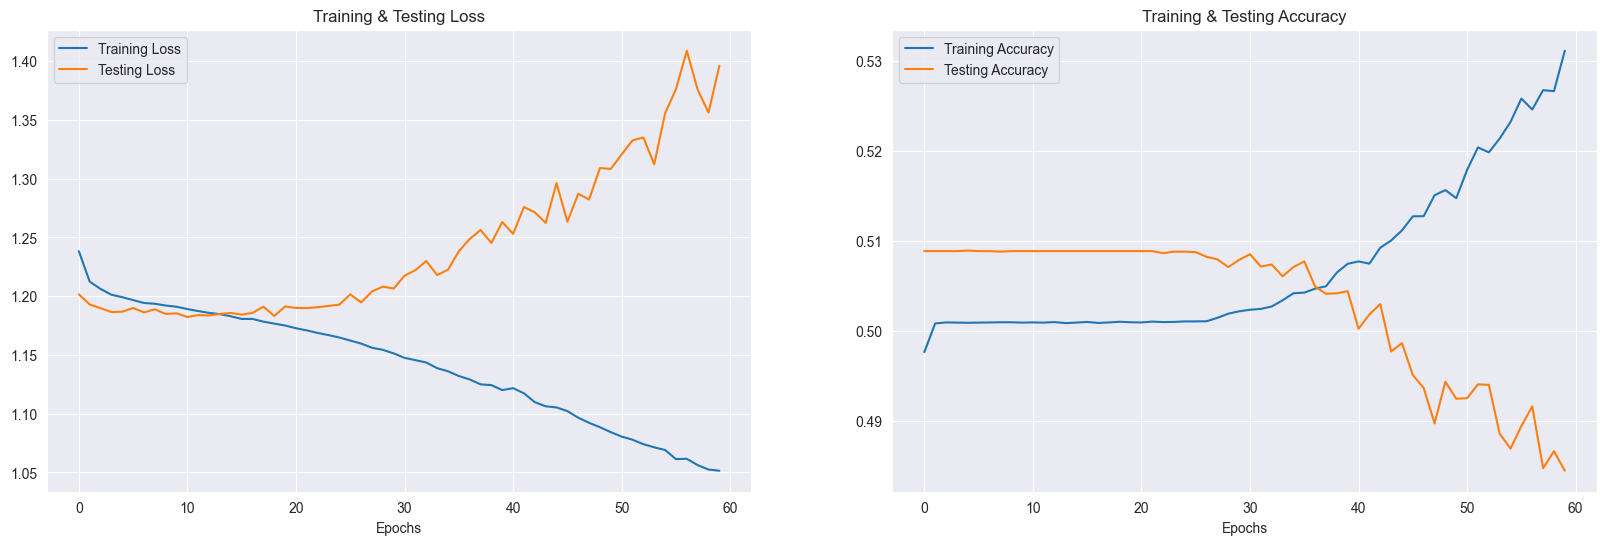

In [48]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(60)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [49]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

547/547 [==============================] - 5s 10ms/step


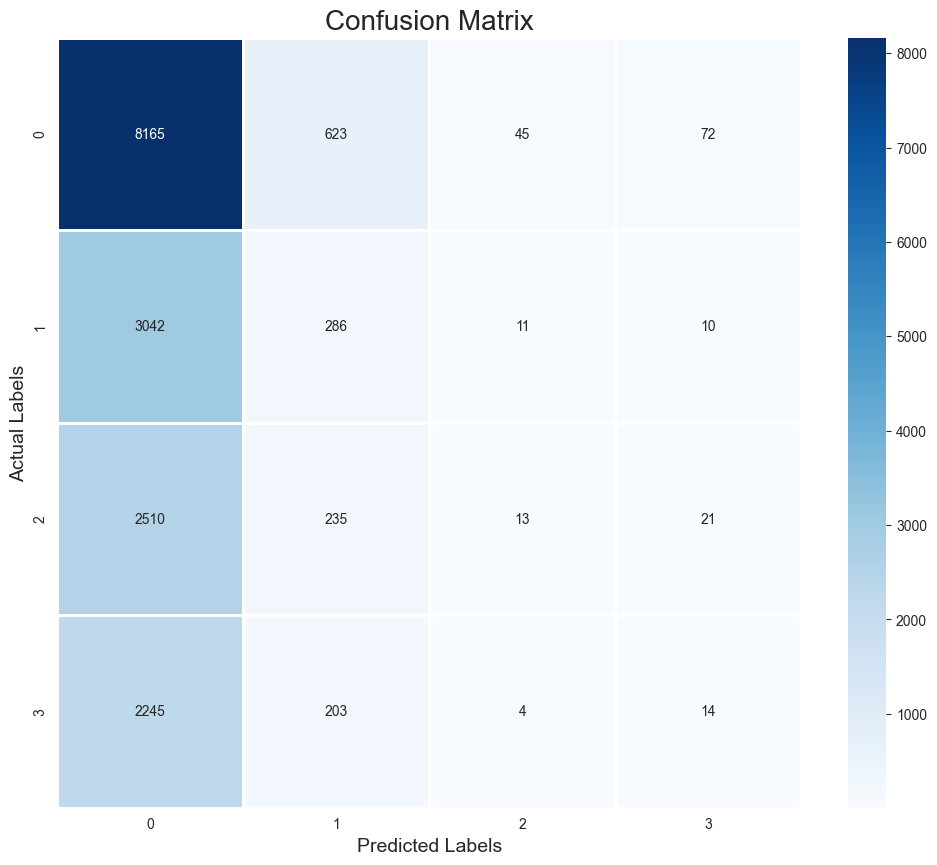

In [50]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.92      0.66      8905
           1       0.21      0.09      0.12      3349
           2       0.18      0.00      0.01      2779
           3       0.12      0.01      0.01      2466

    accuracy                           0.48     17499
   macro avg       0.26      0.25      0.20     17499
weighted avg       0.35      0.48      0.36     17499

